In [2]:
import pandas as pd 
import numpy as np

In [3]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain)->None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None
    
    def node_leaf(self)->str:
        if (self.left or self.right):
            return f"NODE | Information_gain = {self.information_gain} | SPLIT IF X[{self.feature_idx}] < {self.feature_val} | Then Left O/W Right"
        else:
            unique_values, counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value,count in zip(unique_values, counts)])
            return f"LEAF | Label Count = {output} | Pred Probs = {self.prediction_probs}"

In [10]:
class DecisionTree():
    def __init__(self, max_depth=4, min_samples_leaf=1, min_information_gain=0.0 , feature_splitting=None, amount_of_say=None)->None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.feature_splitting = feature_splitting
        self.amount_of_say = amount_of_say
        
    def _entropy(self, class_probabilities: list)->float:
        return sum([-p * np.log2(p) for p in class_probabilities if p > 0])
    
    def _class_probabilities(self, labels: np.array)->np.array:
        unique, counts = np.unique(labels, return_counts=True)
        return counts / counts.sum()
    
    def _data_entropy(self, labels: list)->float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list)->float:
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data:np.array, feature_idx:int, feature_val:float)->tuple:
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]
        return group1, group2
    
    def _select_feature_to_use(self, data:np.array)->list:
        feature_idx = list(range(data.shape[1]-1))
        
        if self.feature_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size= int(np.sqrt(len(feature_idx))))
        elif self.feature_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size= int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx
        return feature_idx_to_use
    
    def _find_best_split(self, data:np.array)->tuple:
        min_part_entropy = 1e9
        feature_idx_to_use = self._select_feature_to_use(data)
        
        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25,100,25))
            
            for val in feature_vals:
                g1, g2 = self._split(data, idx, val)
                part_entropy = self._partition_entropy([g1[:,-1], g2[:,-1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = val
                    g1_min, g2_min = g1,g2
        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy
    
    def _find_label_probs(self, data:np.array)->np.array:
        labels_as_integers = data[:,-1].astype(int)
        unique, counts = np.unique(labels_as_integers, return_counts=True)
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)
        label_probabilities[unique] = counts / counts.sum()
        return label_probabilities
    
    def _create_tree(self, data:np.array, current_depth:int)->TreeNode:
        if current_depth > self.max_depth:
            return None
        
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        label_probabilities = self._find_label_probs(data)
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        node = TreeNode(data, split_feature_idx, split_feature_val,
                        label_probabilities, information_gain)
        
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        elif information_gain < self.min_information_gain:
            return node
        
        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right= self._create_tree(split_2_data, current_depth)
        return node
    
    def _predict_one_sample(self, X:np.array)->np.array:
        node = self.tree
        
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right
        return pred_probs
    
    def train(self, X_train:np.array, y_train:np.array)->None:
        self.labels_in_train = np.unique(y_train)
        train_data = np.concatenate((X_train, np.reshape(y_train, (-1,1))), axis=1)
        
        self.tree = self._create_tree(train_data, current_depth=0)
        self.feature_importance = dict.fromkeys(range(X_train.shape[1]),0)
        self._calculate_feature_importance(self.tree)
        self.feature_importance = {k: v / total for total in (sum(self.feature_importance.values()),) for k, v in self.feature_importance.items()}
        
    def _predict_proba(self, X_set:np.array)->np.array:
        pred_proba = np.apply_along_axis(self._predict_one_sample,1,X_set)
        return pred_proba
    
    def predict(self, X_set:np.array):
        pred_proba = self._predict_proba(X_set)
        preds = np.argmax(pred_proba, axis=1)
        return preds
    
    def _print_recursive(self, node:TreeNode, level=0)->None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_leaf())
            self._print_recursive(node.right, level + 1)
            
    def print_tree(self)->None:
        self._print_recursive(node=self.tree)
        
    def _calculate_feature_importance(self, node):
        if node != None:
            self.feature_importance[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)

In [16]:
def train_test_split(X,y, random_seed=42, test_size=0.2):
    n = X.shape[0]
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(n)
    test_size = int(n * test_size)
    test_data = shuffled_indices[:test_size]
    train_data = shuffled_indices[test_size:]
    
    X_train, X_test = X[train_data], X[test_data]
    y_train, y_test = y[train_data], y[test_data]
    
    return X_train, X_test, y_train, y_test

In [6]:
# Contoh dataset (fitur + label)
X = np.array([[2.5, 3.2], [1.3, 4.5], [3.7, 1.2], [2.8, 3.9], [1.5, 4.2], [3.0, 2.8], [2.1, 3.7], [1.9, 4.1]])
y = np.array([0, 1, 0, 1, 1, 0, 1, 0])  # Label kelas

# Gunakan fungsi train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_seed=42)

# Cek hasilnya
print("X_train:\n", X_train)
print("y_train:\n", y_train)
print("X_test:\n", X_test)
print("y_test:\n", y_test)


X_train:
 [[2.5 3.2]
 [1.9 4.1]
 [3.7 1.2]
 [1.5 4.2]
 [2.8 3.9]
 [2.1 3.7]]
y_train:
 [0 0 0 1 1 1]
X_test:
 [[1.3 4.5]
 [3.  2.8]]
y_test:
 [1 0]


In [ ]:
accurations = []
for i in range(1,14):
    tree = DecisionTree(max_depth=i, min_samples_leaf=1)
    tree.train(X_train, y_train)
    train_preds = tree.predict(X_train)
    test_preds = tree.predict(X_test)
    accurations.append(sum(test_preds == y_test) / len(y_test))
    print("Depth", i)
    print("Train Accuracy", sum(train_preds == y_train) / len(y_train))
    print("Test Accuracy", sum(test_preds == y_test) / len(y_test))
    print()

Depth 1
Train Accuracy 0.8333333333333334
Test Accuracy 1.0

Depth 2
Train Accuracy 0.8333333333333334
Test Accuracy 0.5

Depth 3
Train Accuracy 1.0
Test Accuracy 1.0

Depth 4
Train Accuracy 1.0
Test Accuracy 1.0

Depth 5
Train Accuracy 1.0
Test Accuracy 1.0

Depth 6
Train Accuracy 1.0
Test Accuracy 1.0

Depth 7
Train Accuracy 1.0
Test Accuracy 1.0

Depth 8
Train Accuracy 1.0
Test Accuracy 1.0

Depth 9
Train Accuracy 1.0
Test Accuracy 1.0

Depth 10
Train Accuracy 1.0
Test Accuracy 1.0

Depth 11
Train Accuracy 1.0
Test Accuracy 1.0

Depth 12
Train Accuracy 1.0
Test Accuracy 1.0

Depth 13
Train Accuracy 1.0
Test Accuracy 1.0



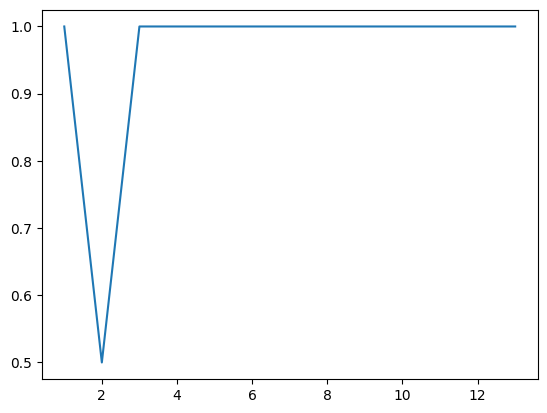

In [15]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,14)),accurations)

In [11]:
# Buat objek Decision Tree dan latih model dengan data training
tree = DecisionTree(max_depth=5, min_samples_leaf=1)
tree.train(X_train, y_train)

# Prediksi menggunakan data uji
y_pred = tree.predict(X_test)

# Output hasil prediksi
print("Prediksi:", y_pred)
print("Label asli:", y_test)


Prediksi: [1 0]
Label asli: [1 0]


In [12]:
X_testing = np.array([[2.0, 3.0], [1.3, 4.6]])
y_pred = tree.predict(X_test)

print("Hasil Prediksi:", y_pred)


Hasil Prediksi: [1 0]
